In [1]:
import tensorflow as tf
import keras
from keras import layers, models
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

import os
import cv2
from PIL import Image
import datetime

In [2]:
# NEEDED
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# 1) GAN Digit "8" Generator

## Load Dataset

In [27]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_all = np.concatenate((X_train, X_test), axis=0)
img_shape = (28, 28, 1)

In [29]:
# pick just "8" digits
y_all = np.concatenate((y_train, y_test), axis=0)
X_all = X_all[y_all == 8]

In [28]:
# Create tf Dataset
dataset = tf.data.Dataset.from_tensor_slices(X_all)

# preprocessing
def preprocess_image(img):
    img = tf.cast(img, dtype=tf.float32) / 255.0
    img = tf.reshape(img, shape=(28, 28, 1))
    return img

dataset = dataset.map(preprocess_image)

# shuffle and batch
batch_size = 32
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

## Define Discriminator

In [6]:
# define layers
inputs = layers.Input(shape=img_shape)

x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same")(inputs)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.BatchNormalization()(x)

x = layers.GlobalMaxPooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

# define model
discriminator = models.Model(inputs, outputs)

## Define Generator

In [7]:
latent_dim = 128

# define layers
inputs = layers.Input(shape=(latent_dim,))

x = layers.Dense(7 * 7 * 128)(inputs)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Reshape((7, 7, 128))(x)

x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.BatchNormalization()(x)

outputs = layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid")(x)

# define model
generator = models.Model(inputs, outputs)

## Optimizers, Losses and Train Step

In [8]:
# optimizers
disc_opt = keras.optimizers.Adam(learning_rate=0.0003)
gen_opt = keras.optimizers.Adam(learning_rate=0.0004)

# losses
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

In [9]:
# train step
@tf.function
def train_step(real_images):
    ## image generation
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    generated_images = generator(random_latent_vectors)
    combined_images = tf.concat([generated_images, real_images], axis=0)
    
    # labels with random noise
    gen_labels = tf.ones((batch_size, 1)) 
    gen_labels -= tf.random.uniform(gen_labels.shape, maxval=0.2)
    real_labels = tf.zeros((real_images.shape[0], 1))
    real_labels += tf.random.uniform(real_labels.shape, maxval=0.2)
    
    labels = tf.concat(
        [gen_labels, real_labels], axis=0
    )
    
    # Train the discriminator
    with tf.GradientTape() as tape:
        preds = discriminator(combined_images)
        disc_loss = loss_fn(labels, preds)
    grads = tape.gradient(disc_loss, discriminator.trainable_weights)
    disc_opt.apply_gradients(zip(grads, discriminator.trainable_weights))
    
    # create random vectors
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # give labels as "real" labels
    misleading_labels = tf.zeros((batch_size, 1))
    
    # Train the generator
    with tf.GradientTape() as tape:
        preds = discriminator(generator(random_latent_vectors))
        gen_loss = loss_fn(misleading_labels, preds)
    grads = tape.gradient(gen_loss, generator.trainable_weights)
    gen_opt.apply_gradients(zip(grads, generator.trainable_weights))
    
    return disc_loss, gen_loss, generated_images

## Training GAN

In [10]:
epochs = 20
img_save_dir = "generated_images/"
model_save_dir = "model/"

In [11]:
# tensorboard writer
# use this command in cmd: "%tensorboard --logdir logs/gradient_tape"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
disc_log_dir = 'logs/gradient_tape/' + current_time + '/disc'
gen_log_dir = 'logs/gradient_tape/' + current_time + '/gen'
disc_summary_writer = tf.summary.create_file_writer(disc_log_dir)
gen_summary_writer = tf.summary.create_file_writer(gen_log_dir)

In [12]:
disc_losses, gen_losses = [], []
tensorboard_step_count = 0

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    for step, real_images in enumerate(dataset):
        # train disc and gen for one batch
        disc_loss, gen_loss, generated_images = train_step(real_images)
        
        disc_losses.append(float(disc_loss))
        gen_losses.append(float(gen_loss))
        
        tensorboard_step_count += 1
        
        # logging info
        if step % 200 == 0:
            # metrics
            print("discriminator loss at step {}: {:.2f}".format(step, disc_loss))
            print("adversarial loss at step {}: {:.2f}".format(step, gen_loss))
            
            # type losses to tensorboard
            with disc_summary_writer.as_default():
                tf.summary.scalar('loss', float(disc_loss), step=tensorboard_step_count)
                
            with gen_summary_writer.as_default():
                tf.summary.scalar('loss', float(gen_loss), step=tensorboard_step_count)
            
            # save one image
            img = keras.preprocessing.image.array_to_img(
                generated_images[0] * 255.0, scale=False
            )
            img.save(os.path.join(img_save_dir, "generated_img" + str(epoch) + "_" + str(step) + ".png"))
    
    # save weights at the end of each n epoch
    if epoch % 5 == 0:
        discriminator.save_weights(os.path.join(model_save_dir, "disc_" + "epoch" + str(epoch)) + "/disc")
        generator.save_weights(os.path.join(model_save_dir, "gen_" + "epoch" + str(epoch)) + "/gen")

Epoch: 0
discriminator loss at step 0: 0.71
adversarial loss at step 0: 0.68
discriminator loss at step 100: 0.33
adversarial loss at step 100: 2.06
discriminator loss at step 200: 0.32
adversarial loss at step 200: 2.30
Epoch: 1
discriminator loss at step 0: 0.31
adversarial loss at step 0: 2.22
discriminator loss at step 100: 0.33
adversarial loss at step 100: 2.26
discriminator loss at step 200: 0.31
adversarial loss at step 200: 2.33
Epoch: 2
discriminator loss at step 0: 0.32
adversarial loss at step 0: 2.23
discriminator loss at step 100: 0.38
adversarial loss at step 100: 1.91
discriminator loss at step 200: 0.38
adversarial loss at step 200: 1.89
Epoch: 3
discriminator loss at step 0: 0.38
adversarial loss at step 0: 2.01
discriminator loss at step 100: 0.44
adversarial loss at step 100: 1.55
discriminator loss at step 200: 0.41
adversarial loss at step 200: 1.64
Epoch: 4
discriminator loss at step 0: 0.40
adversarial loss at step 0: 2.18
discriminator loss at step 100: 0.40
ad

Epoch: 37
discriminator loss at step 0: 0.62
adversarial loss at step 0: 1.17
discriminator loss at step 100: 0.67
adversarial loss at step 100: 0.93
discriminator loss at step 200: 0.63
adversarial loss at step 200: 0.90
Epoch: 38
discriminator loss at step 0: 0.61
adversarial loss at step 0: 1.37
discriminator loss at step 100: 0.59
adversarial loss at step 100: 0.98
discriminator loss at step 200: 0.63
adversarial loss at step 200: 0.97
Epoch: 39
discriminator loss at step 0: 0.59
adversarial loss at step 0: 1.35
discriminator loss at step 100: 0.54
adversarial loss at step 100: 1.13
discriminator loss at step 200: 0.62
adversarial loss at step 200: 0.97
Epoch: 40
discriminator loss at step 0: 0.66
adversarial loss at step 0: 1.05
discriminator loss at step 100: 0.63
adversarial loss at step 100: 0.76
discriminator loss at step 200: 0.62
adversarial loss at step 200: 0.81
Epoch: 41
discriminator loss at step 0: 0.67
adversarial loss at step 0: 1.17
discriminator loss at step 100: 0.

## Plot Losses

In [13]:
def plot_losses(disc_losses, gen_losses):
    plt.figure()
    plt.plot(range(len(disc_losses)), disc_losses, color="blue", label="discriminator loss")
    plt.plot(range(len(gen_losses)), gen_losses, color="orange", label="generator loss")
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


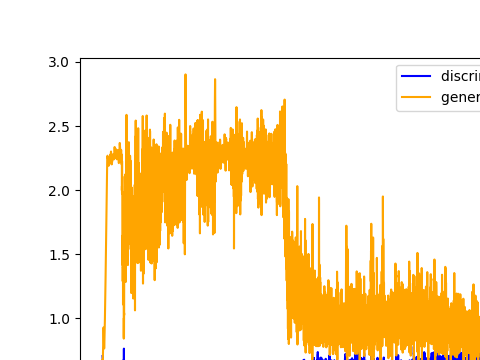

In [14]:
plot_losses(disc_losses, gen_losses)

<IPython.core.display.Javascript object>


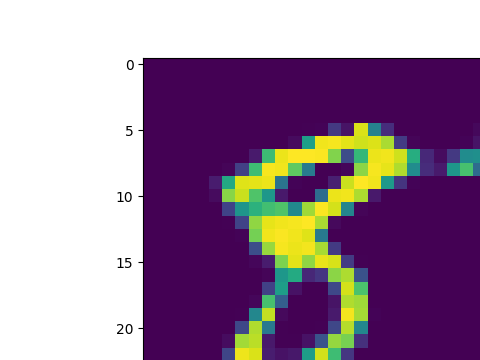

In [15]:
plt.figure()
plt.imshow(generated_images[10].numpy().reshape((28, 28)))

## Generate Images

In [16]:
def generate_images(num_images=10):
    random_vectors = tf.random.normal(shape=(num_images, latent_dim))
    images = generator(random_vectors)
    return images.numpy()

<IPython.core.display.Javascript object>


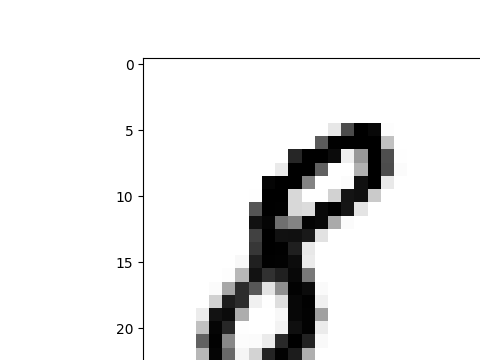

In [17]:
plt.figure()
plt.imshow(generate_images(1).reshape(28, 28), cmap="gray_r")

In [20]:
def generate_show_images(num_images=16):
    generated_images = generate_images(num_images)
    r, c = int(num_images ** 0.5), int(num_images ** 0.5 )
    fig, ax = plt.subplots(nrows=r, ncols=c, figsize=(10, 8))
    for row in range(r):
        for col in range(c):
            img = generated_images[row*c + col].reshape(28, 28)
            ax[row, col].imshow(img, cmap="gray_r")
    plt.show()

<IPython.core.display.Javascript object>


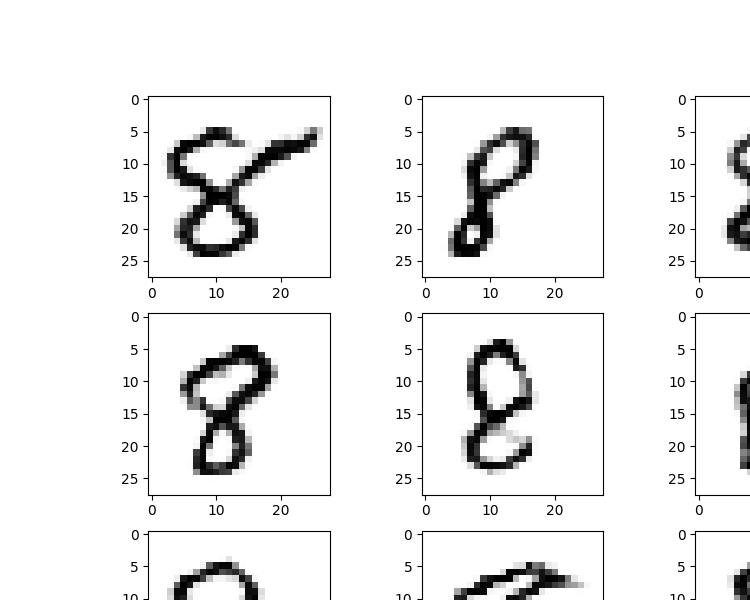

In [23]:
generate_show_images(num_images=9)

# 2) GAN Digit Generator

## Load Dataset

In [39]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_all = np.concatenate((X_train, X_test), axis=0)
img_shape = (28, 28, 1)

In [40]:
# Create tf Dataset
dataset = tf.data.Dataset.from_tensor_slices(X_all)

# preprocessing
def preprocess_image(img):
    img = tf.cast(img, dtype=tf.float32) / 255.0
    img = tf.reshape(img, shape=(28, 28, 1))
    return img

dataset = dataset.map(preprocess_image)

# shuffle and batch
batch_size = 64
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

## Define Discriminator

In [41]:
# define layers
inputs = layers.Input(shape=img_shape)

x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same")(inputs)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.BatchNormalization()(x)

x = layers.GlobalMaxPooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

# define model
discriminator = models.Model(inputs, outputs)

## Define Generator

In [42]:
latent_dim = 128

# define layers
inputs = layers.Input(shape=(latent_dim,))

x = layers.Dense(7 * 7 * 128)(inputs)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Reshape((7, 7, 128))(x)

x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.BatchNormalization()(x)

outputs = layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid")(x)

# define model
generator = models.Model(inputs, outputs)

## Optimizers, Losses and Train Step

In [43]:
# optimizers
disc_opt = keras.optimizers.Adam(learning_rate=0.0003)
gen_opt = keras.optimizers.Adam(learning_rate=0.0004)

# losses
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

In [44]:
# train step
@tf.function
def train_step(real_images):
    ## image generation
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    generated_images = generator(random_latent_vectors)
    combined_images = tf.concat([generated_images, real_images], axis=0)
    
    # labels with random noise
    gen_labels = tf.ones((batch_size, 1)) 
    gen_labels -= tf.random.uniform(gen_labels.shape, maxval=0.2)
    real_labels = tf.zeros((real_images.shape[0], 1))
    real_labels += tf.random.uniform(real_labels.shape, maxval=0.2)
    
    labels = tf.concat(
        [gen_labels, real_labels], axis=0
    )
    
    # Train the discriminator
    with tf.GradientTape() as tape:
        preds = discriminator(combined_images)
        disc_loss = loss_fn(labels, preds)
    grads = tape.gradient(disc_loss, discriminator.trainable_weights)
    disc_opt.apply_gradients(zip(grads, discriminator.trainable_weights))
    
    # create random vectors
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # give labels as "real" labels
    misleading_labels = tf.zeros((batch_size, 1))
    
    # Train the generator
    with tf.GradientTape() as tape:
        preds = discriminator(generator(random_latent_vectors))
        gen_loss = loss_fn(misleading_labels, preds)
    grads = tape.gradient(gen_loss, generator.trainable_weights)
    gen_opt.apply_gradients(zip(grads, generator.trainable_weights))
    
    return disc_loss, gen_loss, generated_images

## Training GAN

In [79]:
epochs = 60
img_save_dir = "generated_images/"
model_save_dir = "model/"

In [48]:
# tensorboard writer
# use this command in cmd: "%tensorboard --logdir logs/gradient_tape"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
disc_log_dir = 'logs/gradient_tape/' + current_time + '/disc'
gen_log_dir = 'logs/gradient_tape/' + current_time + '/gen'
disc_summary_writer = tf.summary.create_file_writer(disc_log_dir)
gen_summary_writer = tf.summary.create_file_writer(gen_log_dir)

In [80]:
disc_losses, gen_losses = [], []
tensorboard_step_count = 0

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    for step, real_images in enumerate(dataset):
        # train disc and gen for one batch
        disc_loss, gen_loss, generated_images = train_step(real_images)
        
        disc_losses.append(float(disc_loss))
        gen_losses.append(float(gen_loss))
        
        # logging info
        if step % 200 == 0:
            # metrics
            print("discriminator loss at step {}: {:.2f}".format(step, disc_loss))
            print("adversarial loss at step {}: {:.2f}".format(step, gen_loss))
            
            # type losses to tensorboard
            with disc_summary_writer.as_default():
                tf.summary.scalar('loss', float(disc_loss), step=tensorboard_step_count)
                
            with gen_summary_writer.as_default():
                tf.summary.scalar('loss', float(gen_loss), step=tensorboard_step_count)
            
            tensorboard_step_count += 1
            
            # save one image
            img = keras.preprocessing.image.array_to_img(
                generated_images[0] * 255.0, scale=False
            )
            img.save(os.path.join(img_save_dir, "generated_img" + str(epoch) + "_" + str(step) + ".png"))
    
    # save weights at the end of each n epoch
    if epoch % 5 == 0:
        discriminator.save_weights(os.path.join(model_save_dir, "disc_" + "epoch" + str(epoch)) + "/disc")
        generator.save_weights(os.path.join(model_save_dir, "gen_" + "epoch" + str(epoch)) + "/gen")

Epoch: 40
discriminator loss at step 0: 0.66
adversarial loss at step 0: 1.30
discriminator loss at step 200: 0.65
adversarial loss at step 200: 0.76
discriminator loss at step 400: 0.62
adversarial loss at step 400: 0.95
discriminator loss at step 600: 0.62
adversarial loss at step 600: 0.98
discriminator loss at step 800: 0.64
adversarial loss at step 800: 0.93
discriminator loss at step 1000: 0.64
adversarial loss at step 1000: 0.95
Epoch: 41
discriminator loss at step 0: 0.60
adversarial loss at step 0: 1.10
discriminator loss at step 200: 0.64
adversarial loss at step 200: 0.69
discriminator loss at step 400: 0.62
adversarial loss at step 400: 0.88
discriminator loss at step 600: 0.63
adversarial loss at step 600: 0.88
discriminator loss at step 800: 0.63
adversarial loss at step 800: 0.89
discriminator loss at step 1000: 0.60
adversarial loss at step 1000: 0.99
Epoch: 42
discriminator loss at step 0: 0.62
adversarial loss at step 0: 0.91
discriminator loss at step 200: 0.63
adver

discriminator loss at step 800: 0.62
adversarial loss at step 800: 0.77
discriminator loss at step 1000: 0.66
adversarial loss at step 1000: 0.96
Epoch: 59
discriminator loss at step 0: 0.63
adversarial loss at step 0: 0.93
discriminator loss at step 200: 0.66
adversarial loss at step 200: 0.95
discriminator loss at step 400: 0.59
adversarial loss at step 400: 0.84
discriminator loss at step 600: 0.64
adversarial loss at step 600: 0.94
discriminator loss at step 800: 0.63
adversarial loss at step 800: 0.92
discriminator loss at step 1000: 0.66
adversarial loss at step 1000: 0.94


## Plot Losses

In [81]:
def plot_losses(disc_losses, gen_losses):
    plt.figure()
    plt.plot(range(len(disc_losses)), disc_losses, color="blue", label="discriminator loss")
    plt.plot(range(len(gen_losses)), gen_losses, color="orange", label="generator loss")
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


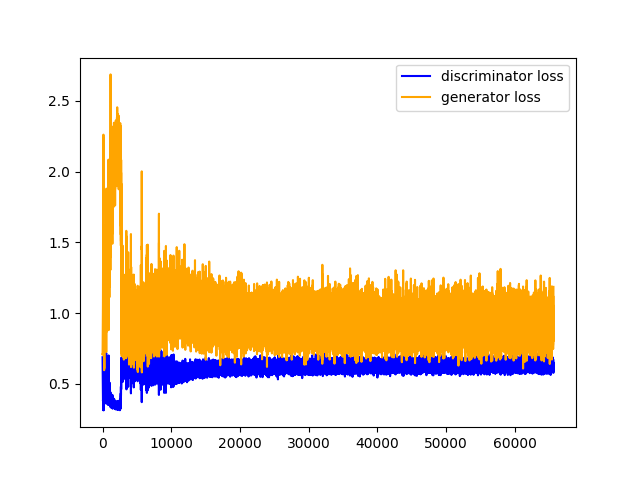

In [82]:
plot_losses(disc_losses, gen_losses)

<IPython.core.display.Javascript object>


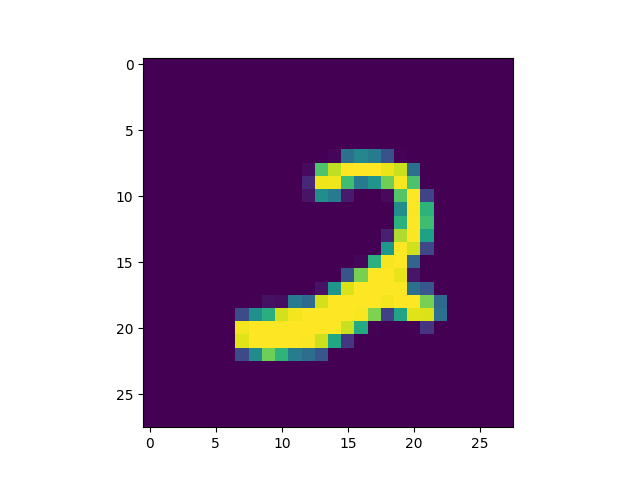

In [83]:
plt.figure()
plt.imshow(generated_images[10].numpy().reshape((28, 28)))

## Generate Images

In [84]:
def generate_images(num_images=10):
    random_vectors = tf.random.normal(shape=(num_images, latent_dim))
    images = generator(random_vectors)
    return images.numpy()

In [85]:
def generate_show_images(num_images=16):
    generated_images = generate_images(num_images)
    r, c = int(num_images ** 0.5), int(num_images ** 0.5 )
    fig, ax = plt.subplots(nrows=r, ncols=c, figsize=(10, 8))
    for row in range(r):
        for col in range(c):
            img = generated_images[row*c + col].reshape(28, 28)
            ax[row, col].imshow(img, cmap="gray_r")
    plt.show()

<IPython.core.display.Javascript object>


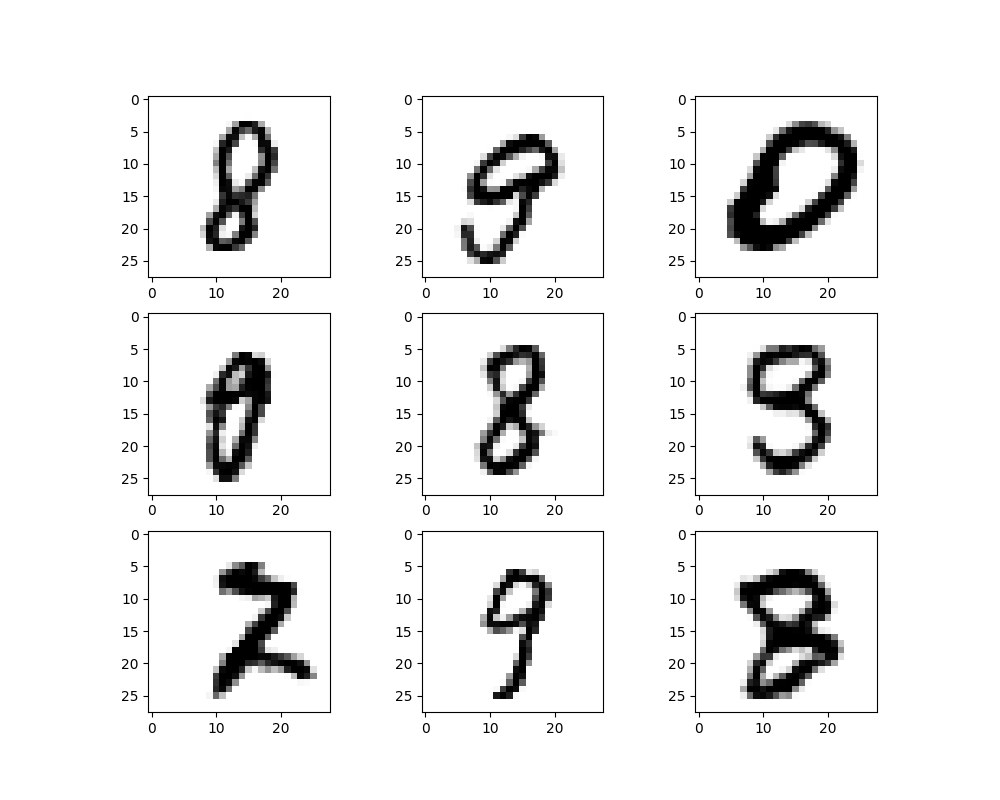

In [90]:
generate_show_images(num_images=9)

# 3) Conditional GAN Digit Generator

## Load Dataset

In [4]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_all = np.concatenate((X_train, X_test), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)
y_all = np.expand_dims(y_all, axis=-1)
img_shape = (28, 28, 1)
num_classes = len(set(y_all.ravel()))

In [5]:
# Create tf Dataset
dataset = tf.data.Dataset.from_tensor_slices((X_all, y_all))

# preprocessing
def preprocess_image(img, label):
    img = tf.cast(img, dtype=tf.float32) / 255.0
    img = tf.reshape(img, shape=(28, 28, 1))
    return img, label

dataset = dataset.map(preprocess_image)

# shuffle and batch
batch_size = 64
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

## Define Discriminator

In [6]:
# define layers
## label input
in_label = layers.Input(shape=(1,))
label_embedding = layers.Embedding(num_classes, 50)(in_label)
# scale up to image dimensions
n_nodes = img_shape[0] * img_shape[1]
label_x = layers.Dense(n_nodes)(label_embedding)
label_x = layers.Reshape((img_shape[0], img_shape[1], 1))(label_x)

## image input
in_image = layers.Input(shape=img_shape)

# concatenate labels and images
concat = layers.Concatenate()([in_image, label_x])

x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same")(concat)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.BatchNormalization()(x)

x = layers.GlobalMaxPooling2D()(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(1)(x)

# define model
discriminator = models.Model(inputs=[in_image, in_label], outputs=out)

In [11]:
keras.utils.plot_model(discriminator, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## Define Generator

In [8]:
latent_dim = 128

# define layers
## label input
in_label = layers.Input(shape=(1,))
label_embedding = layers.Embedding(num_classes, 50)(in_label)
# scale up to low resolution image dimensions
n_nodes = 7 * 7
label_x = layers.Dense(n_nodes)(label_embedding)
label_x = layers.Reshape((7, 7, 1))(label_x)

## image input
in_lat_vec = layers.Input(shape=(latent_dim,))

x = layers.Dense(7 * 7 * 128)(in_lat_vec)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Reshape((7, 7, 128))(x)

# concatenate images and labels
concat = layers.Concatenate()([x, label_x])

x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(concat)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.BatchNormalization()(x)

out = layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid")(x)

# define model
generator = models.Model(inputs=[in_lat_vec, in_label], outputs=out)

In [9]:
keras.utils.plot_model(generator, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## Optimizers, Losses and Train Step

In [12]:
# optimizers
disc_opt = keras.optimizers.Adam(learning_rate=0.0003)
gen_opt = keras.optimizers.Adam(learning_rate=0.0004)

# losses
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
# train step
@tf.function
def train_step(real_images, real_classes):
    ## image generation
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    random_classes = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
    generated_images = generator([random_latent_vectors, random_classes])
    combined_images = tf.concat([generated_images, real_images], axis=0)
    
    # labels with random noise
    gen_labels = tf.ones((batch_size, 1)) 
    gen_labels -= tf.random.uniform(gen_labels.shape, maxval=0.2)
    real_labels = tf.zeros((real_images.shape[0], 1))
    real_labels += tf.random.uniform(real_labels.shape, maxval=0.2)
    
    labels = tf.concat(
        [gen_labels, real_labels], axis=0
    )
    classes = tf.concat(
        [random_classes, real_classes], axis=0
    )
    
    # Train the discriminator
    with tf.GradientTape() as tape:
        preds = discriminator([combined_images, classes])
        disc_loss = loss_fn(labels, preds)
    grads = tape.gradient(disc_loss, discriminator.trainable_weights)
    disc_opt.apply_gradients(zip(grads, discriminator.trainable_weights))
    
    # create random vectors
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    random_classes = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
    # give labels as "real" labels
    misleading_labels = tf.zeros((batch_size, 1))
    
    # Train the generator
    with tf.GradientTape() as tape:
        gen_images = generator([random_latent_vectors, random_classes])
        preds = discriminator([gen_images, random_classes])
        gen_loss = loss_fn(misleading_labels, preds)
    grads = tape.gradient(gen_loss, generator.trainable_weights)
    gen_opt.apply_gradients(zip(grads, generator.trainable_weights))
    
    return disc_loss, gen_loss, generated_images

## Training GAN

In [14]:
# ## Load pretrained GAN (Optional)
# epoch = 30
# discriminator.load_weights(os.path.join("model", "cgan_1", "disc_epoch{}".format(epoch), "disc"))
# generator.load_weights(os.path.join("model", "cgan_1", "gen_epoch{}".format(epoch), "gen"))

In [15]:
epochs = 20
model_name = "cgan_1"
img_save_dir = os.path.join("generated_images", "generated_" + model_name)
model_save_dir = os.path.join("model", model_name)

In [16]:
# tensorboard writer
# use this command in cmd: "%tensorboard --logdir logs/gradient_tape"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
disc_log_dir = 'logs/gradient_tape/' + current_time + '/disc'
gen_log_dir = 'logs/gradient_tape/' + current_time + '/gen'
disc_summary_writer = tf.summary.create_file_writer(disc_log_dir)
gen_summary_writer = tf.summary.create_file_writer(gen_log_dir)

In [20]:
disc_losses, gen_losses = [], []
tensorboard_step_count = 0

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    for step, (real_images, real_classes) in enumerate(dataset):
        # train disc and gen for one batch
        disc_loss, gen_loss, generated_images = train_step(real_images, real_classes)
        
        disc_losses.append(float(disc_loss))
        gen_losses.append(float(gen_loss))
        
        # logging info
        if step % 200 == 0:
            # metrics
            print("discriminator loss at step {}: {:.2f}".format(step, disc_loss))
            print("adversarial loss at step {}: {:.2f}".format(step, gen_loss))
            
            # type losses to tensorboard
            with disc_summary_writer.as_default():
                tf.summary.scalar('loss', float(disc_loss), step=tensorboard_step_count)
                
            with gen_summary_writer.as_default():
                tf.summary.scalar('loss', float(gen_loss), step=tensorboard_step_count)
            
            tensorboard_step_count += 1
            
            # save one image
            img = keras.preprocessing.image.array_to_img(
                generated_images[0] * 255.0, scale=False
            )
            img.save(os.path.join(img_save_dir, "generated_img" + str(epoch) + "_" + str(step) + ".png"))
    
    # save weights at the end of each n epoch
    if epoch % 5 == 0:
        discriminator.save_weights(os.path.join(model_save_dir, "disc_epoch" + str(epoch)) + "/disc")
        generator.save_weights(os.path.join(model_save_dir, "gen_epoch" + str(epoch)) + "/gen")

Epoch: 31
discriminator loss at step 0: 0.59
adversarial loss at step 0: 0.77
discriminator loss at step 200: 0.58
adversarial loss at step 200: 1.21
discriminator loss at step 400: 0.57
adversarial loss at step 400: 0.94
discriminator loss at step 600: 0.55
adversarial loss at step 600: 1.00
discriminator loss at step 800: 0.56
adversarial loss at step 800: 1.18
discriminator loss at step 1000: 0.56
adversarial loss at step 1000: 1.11
Epoch: 32
discriminator loss at step 0: 0.59
adversarial loss at step 0: 1.13
discriminator loss at step 200: 0.58
adversarial loss at step 200: 0.86
discriminator loss at step 400: 0.59
adversarial loss at step 400: 1.16
discriminator loss at step 600: 0.59
adversarial loss at step 600: 1.11
discriminator loss at step 800: 0.58
adversarial loss at step 800: 1.22
discriminator loss at step 1000: 0.55
adversarial loss at step 1000: 1.06
Epoch: 33
discriminator loss at step 0: 0.55
adversarial loss at step 0: 0.99
discriminator loss at step 200: 0.62
adver

discriminator loss at step 800: 0.55
adversarial loss at step 800: 1.02
discriminator loss at step 1000: 0.57
adversarial loss at step 1000: 0.96
Epoch: 50
discriminator loss at step 0: 0.56
adversarial loss at step 0: 1.20
discriminator loss at step 200: 0.59
adversarial loss at step 200: 0.86
discriminator loss at step 400: 0.59
adversarial loss at step 400: 0.88
discriminator loss at step 600: 0.56
adversarial loss at step 600: 0.80
discriminator loss at step 800: 0.60
adversarial loss at step 800: 1.02
discriminator loss at step 1000: 0.54
adversarial loss at step 1000: 0.93


## Plot Losses

In [21]:
def plot_losses(disc_losses, gen_losses):
    plt.figure()
    plt.plot(range(len(disc_losses)), disc_losses, color="blue", label="discriminator loss")
    plt.plot(range(len(gen_losses)), gen_losses, color="orange", label="generator loss")
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


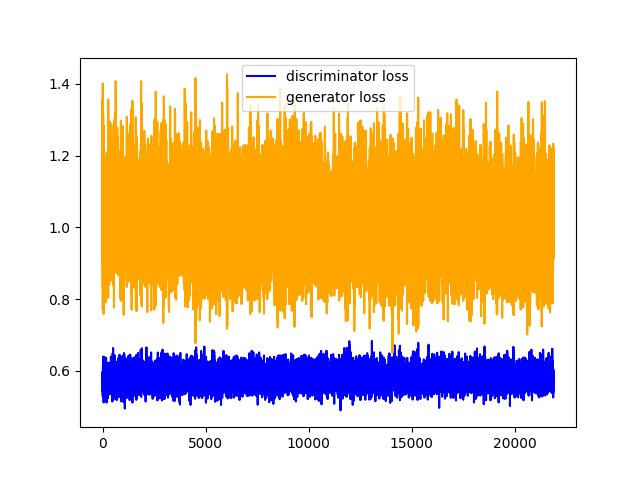

In [22]:
plot_losses(disc_losses, gen_losses)

<IPython.core.display.Javascript object>


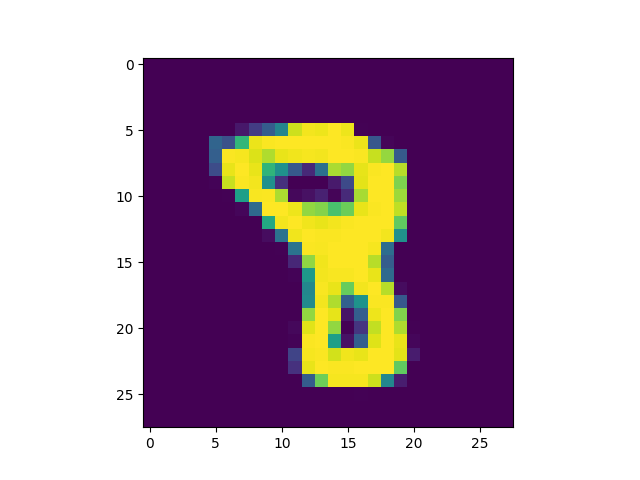

In [23]:
plt.figure()
plt.imshow(generated_images[10].numpy().reshape((28, 28)))

## Generating Images

In [25]:
### To load pretrained model, Run this code
latent_dim = 128
num_classes = 10

# define layers
## label input
in_label = layers.Input(shape=(1,))
label_embedding = layers.Embedding(num_classes, 50)(in_label)
# scale up to low resolution image dimensions
n_nodes = 7 * 7
label_x = layers.Dense(n_nodes)(label_embedding)
label_x = layers.Reshape((7, 7, 1))(label_x)

## image input
in_lat_vec = layers.Input(shape=(latent_dim,))

x = layers.Dense(7 * 7 * 128)(in_lat_vec)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Reshape((7, 7, 128))(x)

# concatenate images and labels
concat = layers.Concatenate()([x, label_x])

x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(concat)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.BatchNormalization()(x)

out = layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid")(x)

# define model
generator = models.Model(inputs=[in_lat_vec, in_label], outputs=out)

# Load Generator
epoch = 50
model_name = "cgan_1"
generator.load_weights(os.path.join("model", model_name, "gen_epoch{}".format(epoch), "gen"))

In [26]:
def generate_images(num_images=10, class_=0):
    random_vectors = tf.random.normal(shape=(num_images, latent_dim))
    class_vec = tf.ones(shape=(num_images, 1)) * class_
    images = generator([random_vectors, class_vec])
    return images.numpy()

In [27]:
def generate_show_image(digit=0):
    plt.figure()
    img = generate_images(1, digit)
    img = img.reshape(28, 28)
    plt.imshow(img, cmap="gray_r")
    plt.title("Generated Digit: {}".format(digit))
    plt.show()

<IPython.core.display.Javascript object>


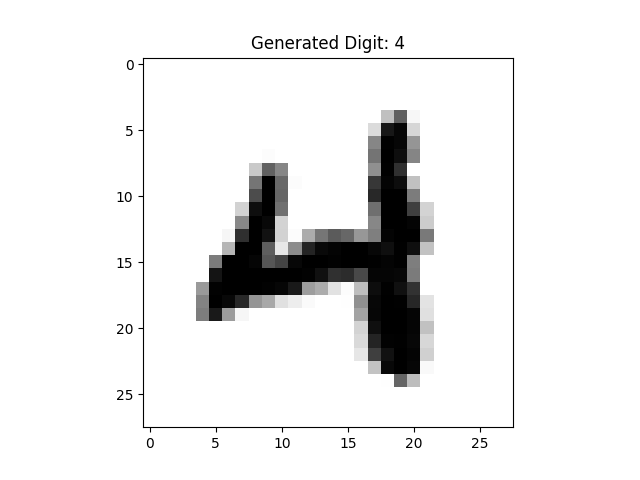

In [33]:
generate_show_image(4)

In [34]:
def generate_show_a_class(num_images=16, class_=0):
    generated_images = generate_images(num_images, class_)
    r, c = int(num_images ** 0.5), int(num_images ** 0.5 )
    if r == 1:
        generate_show_image(class_)
        return
    fig, ax = plt.subplots(nrows=r, ncols=c, figsize=(10, 8))
    for row in range(r):
        for col in range(c):
            img = generated_images[row*c + col].reshape(28, 28)
            ax[row, col].imshow(img, cmap="gray_r")
    plt.show()

<IPython.core.display.Javascript object>


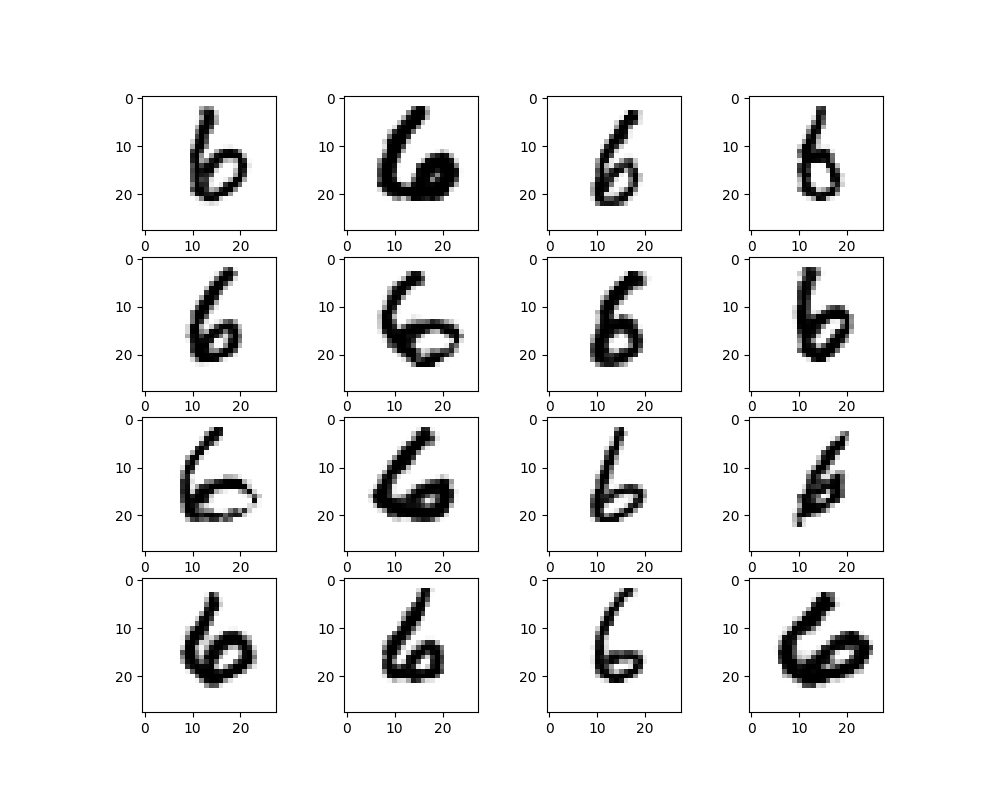

In [35]:
generate_show_a_class(num_images=16, class_=6)

In [36]:
def generate_show_all_classes(images_per_row=10):
    fig, ax = plt.subplots(nrows=num_classes, ncols=images_per_row, figsize=(10, 8))
    ax = np.reshape(ax, (-1, images_per_row))

    for row in range(num_classes):
        generated_images = generate_images(images_per_row, row)
        ax[row, 0].set_ylabel("Digit: {}".format(row))
        for col in range(images_per_row):    
            img = generated_images[col].reshape(28, 28)
            ax[row, col].imshow(img, cmap="gray_r")
            # visual options
            ax[row, col].set_xticks([])
            ax[row, col].set_yticks([])
    plt.show()

<IPython.core.display.Javascript object>


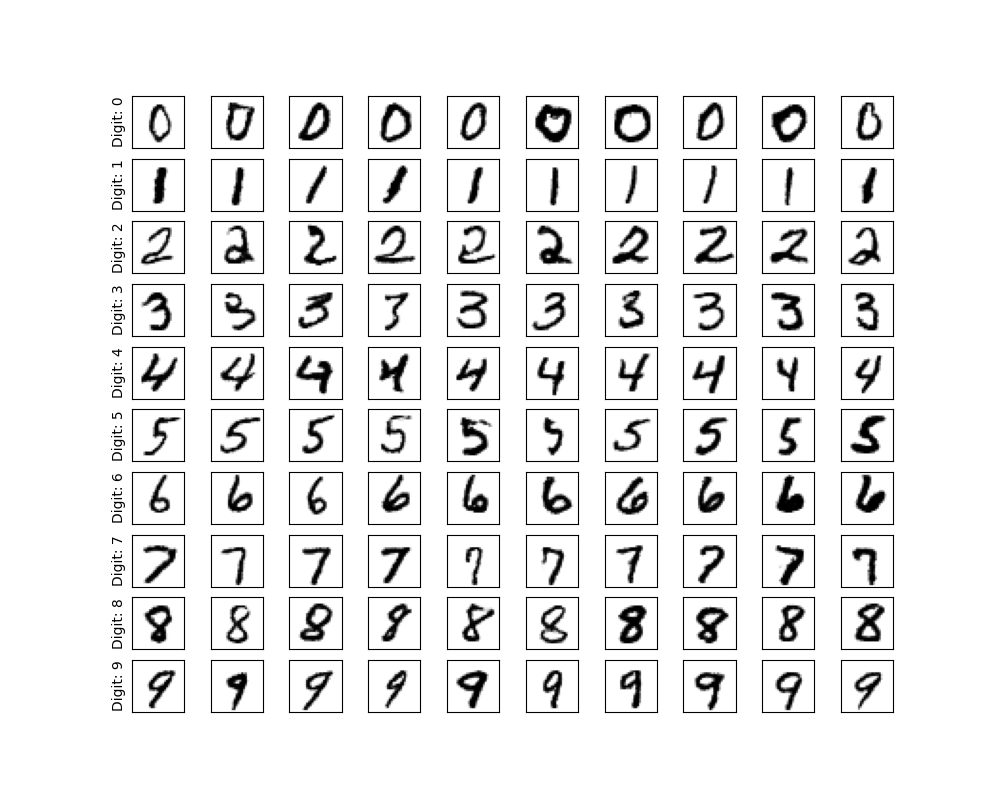

In [38]:
generate_show_all_classes(images_per_row=10)